In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from PIL import Image
import os
import shutil
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, ConfusionMatrixDisplay, classification_report, roc_auc_score
import seaborn as sns
import time
from tensorflow.keras.preprocessing import image

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data

## Loading the data

In [2]:
data_dir = '/kaggle/input/gender-classification-dataset'
print(os.listdir(data_dir))

['Validation', 'Training']


In [3]:
data_training = {}
data_Val = {}

In [4]:
print ("** Gender Classification Dataset **")

for folders_Traing_Or_Testing in os.listdir(data_dir):

    folders_Traing_Or_Testing_path = os.path.join(data_dir,folders_Traing_Or_Testing)

    number_of_samples = 0

    print('**',folders_Traing_Or_Testing,'**')

    for diseases in os.listdir(folders_Traing_Or_Testing_path):

        diseases_path = os.path.join(folders_Traing_Or_Testing_path,diseases)


        samples = len(os.listdir(diseases_path))

        print(diseases , ":", samples)


        number_of_samples = number_of_samples + samples

        if folders_Traing_Or_Testing == "Validation":
          data_Val[diseases] = samples
        else:
          data_training[diseases] = samples


    print("Number of samples for ", folders_Traing_Or_Testing," is ",number_of_samples)
    print("=================================================")

** Gender Classification Dataset **
** Validation **
female : 5841
male : 5808
Number of samples for  Validation  is  11649
** Training **
female : 23243
male : 23766
Number of samples for  Training  is  47009


## Visualize the data

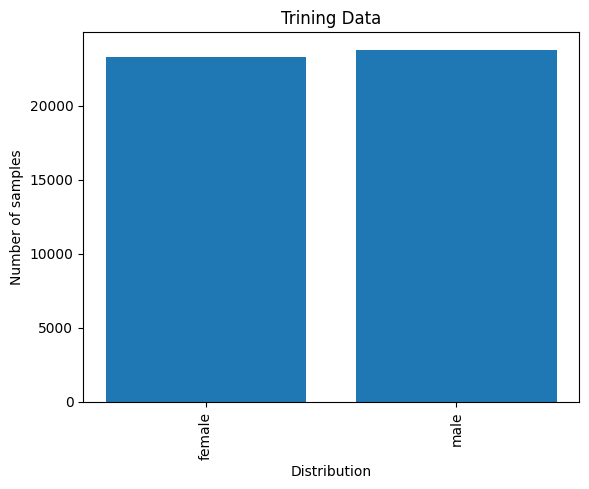

In [5]:
data_training_array = np.array(list(data_training.values()))
plt.bar(data_training.keys(), data_training_array)
plt.xticks(rotation=90)
plt.xlabel("Distribution")
plt.ylabel("Number of samples")
plt.title("Trining Data")
plt.show()

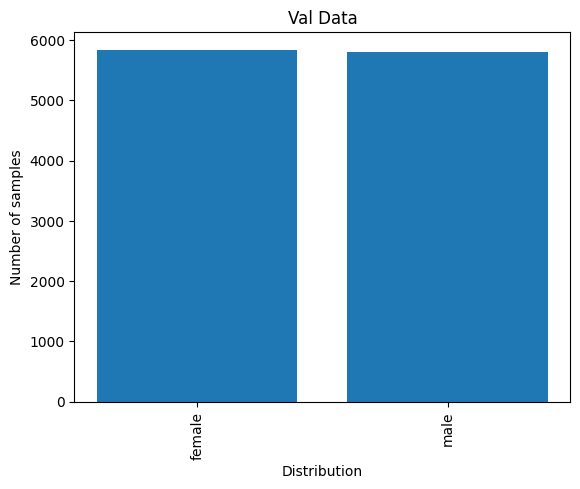

In [6]:
data_testing_array = np.array(list(data_Val.values()))
plt.bar(data_Val.keys(), data_testing_array)
plt.xticks(rotation=90)
plt.xlabel("Distribution")
plt.ylabel("Number of samples")
plt.title("Val Data")
plt.show()

Text(0.5, 1.0, 'female')

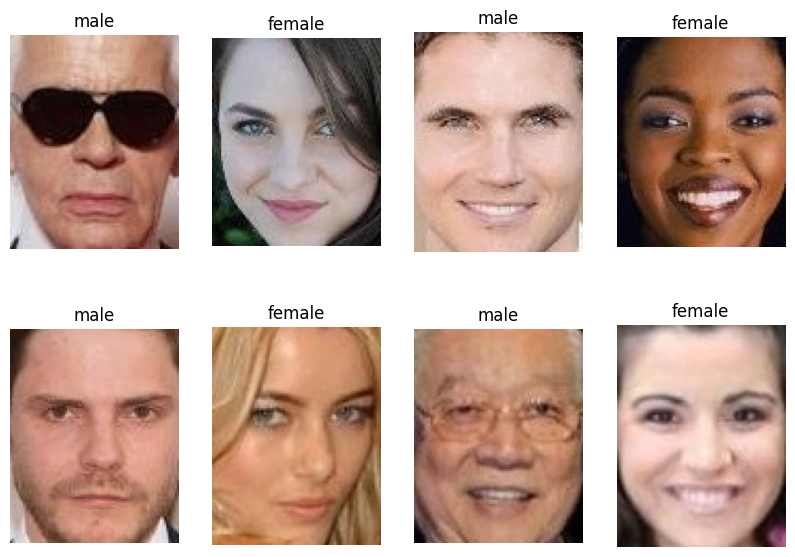

In [7]:
fig = plt.figure(figsize=(10, 7))

rows = 2
columns = 4

m1= np.array(PIL.Image.open(str('/kaggle/input/gender-classification-dataset/Training/male/090548.jpg.jpg')))
f1 = np.array(PIL.Image.open(str('/kaggle/input/gender-classification-dataset/Training/female/131422.jpg.jpg')))
m2= np.array(PIL.Image.open(str('/kaggle/input/gender-classification-dataset/Training/male/090563.jpg.jpg')))
f2 = np.array(PIL.Image.open(str('/kaggle/input/gender-classification-dataset/Training/female/131423.jpg.jpg')))
m3= np.array(PIL.Image.open(str('/kaggle/input/gender-classification-dataset/Training/male/090571.jpg.jpg')))
f3 = np.array(PIL.Image.open(str('/kaggle/input/gender-classification-dataset/Training/female/131429.jpg.jpg')))
m4= np.array(PIL.Image.open(str('/kaggle/input/gender-classification-dataset/Training/male/090597.jpg.jpg')))
f4 = np.array(PIL.Image.open(str('/kaggle/input/gender-classification-dataset/Training/female/131458.jpg.jpg')))


fig.add_subplot(rows, columns, 1)

plt.imshow(m1)
plt.axis('off')
plt.title("male")


fig.add_subplot(rows, columns, 2)

plt.imshow(f1)
plt.axis('off')
plt.title("female")


fig.add_subplot(rows, columns, 3)

plt.imshow(m2)
plt.axis('off')
plt.title("male")


fig.add_subplot(rows, columns, 4)

plt.imshow(f2)
plt.axis('off')
plt.title("female")


fig.add_subplot(rows, columns, 5)

plt.imshow(m3)
plt.axis('off')
plt.title("male")

fig.add_subplot(rows, columns, 6)

plt.imshow(f3)
plt.axis('off')
plt.title("female")


fig.add_subplot(rows, columns, 7)

plt.imshow(m4)
plt.axis('off')
plt.title("male")


fig.add_subplot(rows, columns, 8)

plt.imshow(f4)
plt.axis('off')
plt.title("female")

# Models

In [8]:
img = Image.open('/kaggle/input/gender-classification-dataset/Training/male/090548.jpg.jpg')
img.size

(79, 100)

## Preprocessing

In [9]:
batch_size = 32
img_height = 100
img_width = 100

In [10]:
train_dataset = tf.keras.utils.image_dataset_from_directory('/kaggle/input/gender-classification-dataset/Training',
                                                            shuffle=True,
                                                            batch_size=batch_size,
                                                            label_mode='categorical',
                                                            image_size=(img_height, img_width))

Found 47009 files belonging to 2 classes.


In [11]:
validation_dataset = tf.keras.utils.image_dataset_from_directory('/kaggle/input/gender-classification-dataset/Validation',
                                                            shuffle=True,
                                                            batch_size=batch_size,
                                                            label_mode='categorical',
                                                            image_size=(img_height, img_width))

Found 11649 files belonging to 2 classes.


In [12]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [13]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 292
Number of test batches: 73


In [46]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(factor=0.2),
    layers.RandomContrast(factor=0.2),
  ]
)

## Training

In [15]:
def lr_schedule(epoch):
    initial_lr = 0.0001
    drop = 0.1
    epochs_drop = 10.0
    lr = initial_lr * np.power(drop, np.floor((1+epoch)/epochs_drop))
    return lr

lr_callback = LearningRateScheduler(lr_schedule)

earlystop_callback = EarlyStopping(
  monitor='val_loss',  
  patience=3          
)

In [16]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(2, activation='sigmoid')
])

In [47]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics = ['accuracy'])

In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 100, 100, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                  

In [49]:
epochs = 100
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs,
  callbacks=[earlystop_callback, lr_callback])

Epoch 1/100


2023-09-30 21:44:33.956036: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1470/1470 [==============================] - 38s 24ms/step - loss: 0.1208 - accuracy: 0.9562 - val_loss: 0.0952 - val_accuracy: 0.9651 - lr: 1.0000e-04
Epoch 2/100
1470/1470 [==============================] - 35s 24ms/step - loss: 0.1214 - accuracy: 0.9561 - val_loss: 0.0918 - val_accuracy: 0.9655 - lr: 1.0000e-04
Epoch 3/100
1470/1470 [==============================] - 36s 24ms/step - loss: 0.1176 - accuracy: 0.9569 - val_loss: 0.0938 - val_accuracy: 0.9650 - lr: 1.0000e-04
Epoch 4/100
1470/1470 [==============================] - 40s 27ms/step - loss: 0.1154 - accuracy: 0.9587 - val_loss: 0.1007 - val_accuracy: 0.9639 - lr: 1.0000e-04
Epoch 5/100
1470/1470 [==============================] - 36s 25ms/step - loss: 0.1124 - accuracy: 0.9598 - val_loss: 0.0914 - val_accuracy: 0.9660 - lr: 1.0000e-04
Epoch 6/100
1470/1470 [==============================] - 36s 24ms/step - loss: 0.1120 - accuracy: 0.9596 - val_loss: 0.0910 - val_accuracy: 0.9661 - lr: 1.0000e-04
Epoch 7/100
1470/1470 [=====

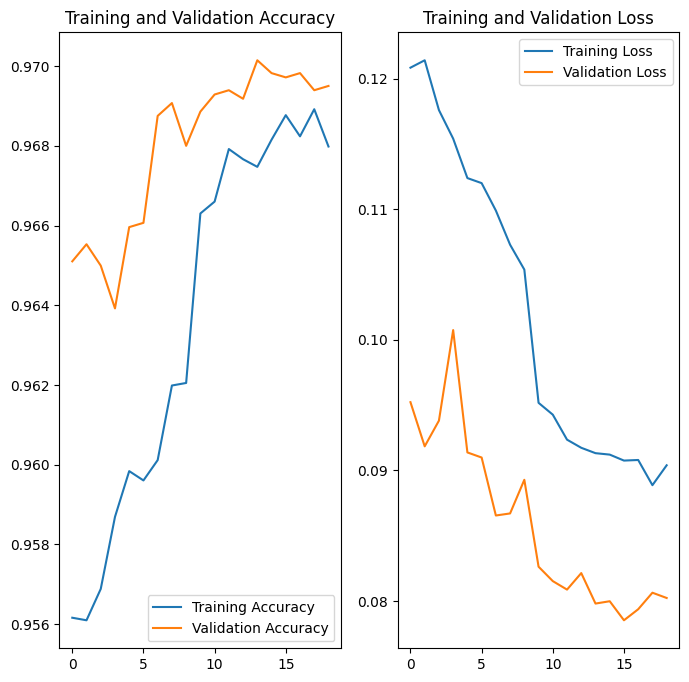

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(19)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [52]:
model.save("/kaggle/working/TheFinalModelGenderClassification9680.h5")

## Evaluation

### Prepeare y and y_hat

In [53]:
all_Pred = []
all_true = []

In [54]:
all_Pred = []
all_true = []
for images, labels in test_dataset:
    predictions = model.predict_on_batch(images)
    
    all_Pred.append(predictions)
    all_true.append(labels)
    
    

In [55]:
all_Pred = np.asarray(all_Pred)
all_true = np.asarray(all_true)

In [56]:
print (all_Pred.shape, all_true.shape)

(73, 32, 2) (73, 32, 2)


In [57]:
all_Pred = all_Pred.reshape(-1, 2)
all_true = all_true.reshape(-1, 2)

In [58]:
print (all_Pred.shape, all_true.shape)

(2336, 2) (2336, 2)


In [59]:
y_hat = []
y = []

In [60]:
for i in range (all_Pred.shape[0]):
    y_hat.append(np.argmax(all_Pred[i]))

y_hat = np.asarray(y_hat)

print(y_hat.shape)


(2336,)


In [61]:
for i in range (all_true.shape[0]):
    y .append(np.argmax(all_true[i]))

y  = np.asarray(y_hat)

print(y .shape)

(2336,)


In [62]:
y_hat

array([0, 0, 0, ..., 0, 1, 1])

In [63]:
y 

array([0, 0, 0, ..., 0, 1, 1])

### Evaluation measures

In [64]:
accuracy = accuracy_score(y, y_hat)

precision = precision_score(y, y_hat, average='weighted')

recall = recall_score(y, y_hat, average='weighted')

f1 = f1_score(y, y_hat, average='weighted')

conf_matrix = confusion_matrix(y, y_hat)


print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print("F1-score:", f1)


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-score: 1.0


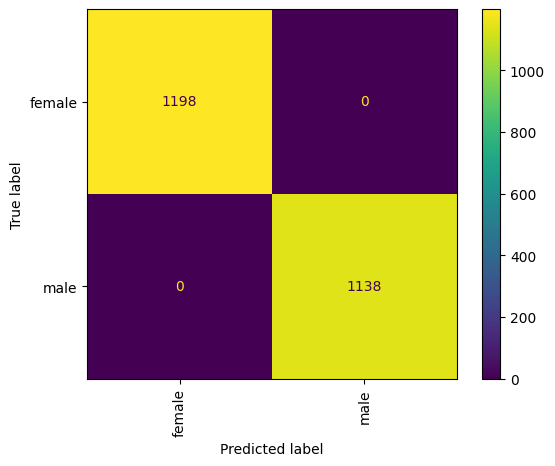

In [65]:
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["female", "male"] )
disp.plot(xticks_rotation='vertical')

### Test with new samples

**Male sample**

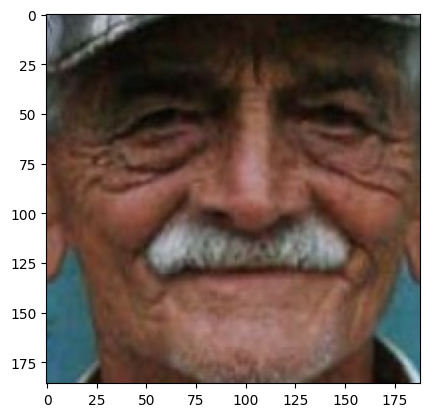

In [66]:
img = PIL.Image.open('/kaggle/input/samples/maleSample.jpg')
# Display the image
plt.imshow(img)
plt.show()

In [67]:
img = image.load_img("/kaggle/input/samples/maleSample.jpg", target_size=(100,100))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

predictions = model.predict(img_batch)
label = np.argmax(predictions)
label

1/1 [==============================] - 0s 85ms/step


1

**Female Sample**

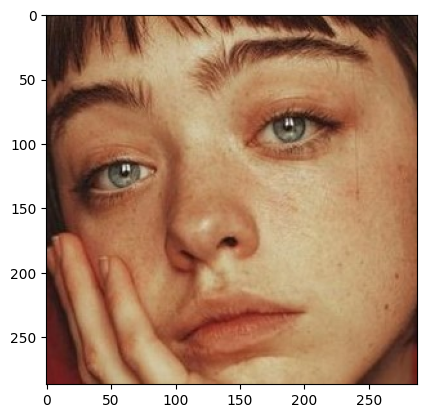

In [68]:
img = PIL.Image.open('/kaggle/input/samples/femaleSample.jpg')
# Display the image
plt.imshow(img)
plt.show()

In [69]:
img = image.load_img("/kaggle/input/samples/femaleSample.jpg", target_size=(100,100))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

predictions = model.predict(img_batch)
label = np.argmax(predictions)
label

1/1 [==============================] - 0s 17ms/step


0

**Male Sample (not cropped)**

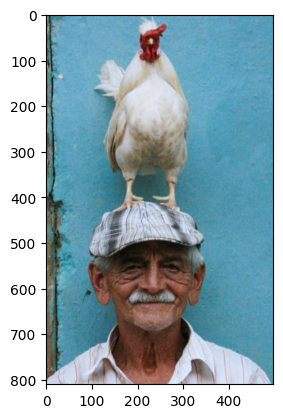

In [70]:
img = PIL.Image.open('/kaggle/input/samplesNotCroppedd/Screenshot 2023-08-17 141844.jpg')
# Display the image
plt.imshow(img)
plt.show()

In [71]:
img = image.load_img("/kaggle/input/samplesNotCroppedd/Screenshot 2023-08-17 141844.jpg", target_size=(100,100))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

predictions = model.predict(img_batch)
label = np.argmax(predictions)
label

1/1 [==============================] - 0s 17ms/step


1

**Female Sample (not cropped)**

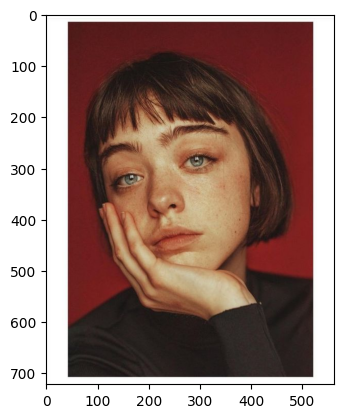

In [72]:
img = PIL.Image.open('/kaggle/input/samplesNotCroppedd/a5e2fed6f02f1fa7944f3fe5177cb219.jpg')
# Display the image
plt.imshow(img)
plt.show()

In [73]:
img = image.load_img("/kaggle/input/samplesNotCroppedd/a5e2fed6f02f1fa7944f3fe5177cb219.jpg", target_size=(100,100))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)

predictions = model.predict(img_batch)
label = np.argmax(predictions)
label

1/1 [==============================] - 0s 18ms/step


1

**This model misclassifies Uncropped images**